# Detection of malaria using CNN

In [157]:
# import the libraries 
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [158]:
# re-size all the images to this
IMAGE_SIZE=[224,224]

train_path='cell_images/Train'
valid_path='cell_images/Test'

In [159]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [160]:
# Import the vgg 16 library as shown below and add preprocessing
# layer to the front of VGG
# here we wil be using imagenet weights

mobilnet=VGG19(input_shape=IMAGE_SIZE+[3],
              weights='imagenet',include_top=False)


In [161]:
# Don't train existing weights
for layer in mobilnet.layers:
    layer.trainable=False

In [162]:
# useful for getting number of output classes
folders=glob('cell_images/Train/*')

In [163]:
folders

['cell_images/Train\\Parasitized', 'cell_images/Train\\Uninfected']

In [164]:
# our layers - you can add more if you want
x = Flatten()(mobilnet.output)

In [165]:
prediction = Dense(len(folders),activation='softmax')(x)

#create a model object
model=Model(inputs=mobilnet.input,outputs=prediction)

In [166]:
# View the structure of the model
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [167]:
from tensorflow.keras.layers import MaxPooling2D

In [168]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",
                 activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 50176)            

In [169]:
# tell the model what cost and optimization methd to use
model.compile(loss="categorical_crossentropy",
             optimizer='adam',
             metrics=['accuracy'])

In [170]:
# Use the Image Data Generator to import the images from the cell_images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [171]:
# Make sure you provide the same target size as initialied for the image size
training_set=train_datagen.flow_from_directory("cell_images/Train",
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical') 

Found 27351 images belonging to 2 classes.


In [172]:
training_set

In [173]:
test_set=test_datagen.flow_from_directory('cell_images/Test',
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='categorical') 

Found 207 images belonging to 2 classes.


In [174]:
test_set

In [175]:
# fit the model
# Rum the cell.It will take some time to execute
r=model.fit(training_set,
            validation_data=test_set,
            epochs=4,
            steps_per_epoch=len(training_set),
            validation_steps=len(test_set)
           )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 855 steps, validate for 7 steps
Epoch 1/4
855/855 [==============================] - 1656s 2s/step - loss: 0.4534 - accuracy: 0.7936 - val_loss: 0.1025 - val_accuracy: 0.9807
Epoch 2/4
855/855 [==============================] - 1612s 2s/step - loss: 0.2163 - accuracy: 0.9307 - val_loss: 0.0876 - val_accuracy: 0.9807
Epoch 3/4
855/855 [==============================] - 1567s 2s/step - loss: 0.2043 - accuracy: 0.9366 - val_loss: 0.0738 - val_accuracy: 0.9758
Epoch 4/4
855/855 [==============================] - 1690s 2s/step - loss: 0.1893 - accuracy: 0.9409 - val_loss: 0.1442 - val_accuracy: 0.9565


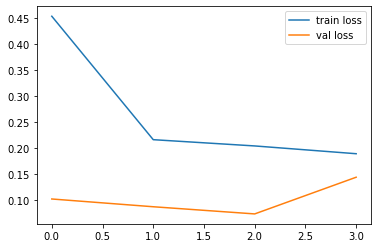

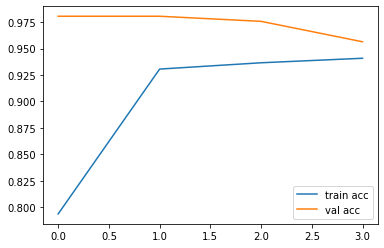

<Figure size 432x288 with 0 Axes>

In [191]:
#plot the loss
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#plot the accuracy
plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [192]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [193]:
y_pred = model.predict(test_set)

In [194]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [195]:
y_pred

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

In [196]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [197]:
model=load_model('model_vgg19.h5')

In [198]:
img=image.load_img('cell_images/Test/Parasitized/C189P150ThinF_IMG_20151203_141406_cell_99.png',target_size=(224,224))

In [199]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [200]:
x.shape

(224, 224, 3)

In [201]:
x=x/255

In [202]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [203]:
model.predict(img_data)

array([[1., 0.]], dtype=float32)

In [204]:
a=np.argmax(model.predict(img_data),axis=1)

In [205]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Infected
